In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
base_folder = "/content/drive/MyDrive/MS/Python Project"
%cd "{base_folder}"

/content/drive/MyDrive/MS/Python Project


In [3]:
import pandas as pd

loan_data = pd.read_csv(f"{base_folder}/data/loan_approval_dataset.csv")
loan_data.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [9]:
import numpy as np


summary_stats = {
    "integers": loan_data.select_dtypes(include=np.integer).agg(['mean','median', 'min', 'max']).to_dict(),
    "categoricals": {col: loan_data[col].unique().tolist() for col in loan_data.select_dtypes(include=['object', 'category']).columns}
}

summary_stats


{'integers': {'loan_id': {'mean': 2135.0,
   'median': 2135.0,
   'min': 1.0,
   'max': 4269.0},
  ' no_of_dependents': {'mean': 2.4987116420707425,
   'median': 3.0,
   'min': 0.0,
   'max': 5.0},
  ' income_annum': {'mean': 5059123.9166081045,
   'median': 5100000.0,
   'min': 200000.0,
   'max': 9900000.0},
  ' loan_amount': {'mean': 15133450.456781447,
   'median': 14500000.0,
   'min': 300000.0,
   'max': 39500000.0},
  ' loan_term': {'mean': 10.900445069102835,
   'median': 10.0,
   'min': 2.0,
   'max': 20.0},
  ' cibil_score': {'mean': 599.9360505973295,
   'median': 600.0,
   'min': 300.0,
   'max': 900.0},
  ' residential_assets_value': {'mean': 7472616.537830873,
   'median': 5600000.0,
   'min': -100000.0,
   'max': 29100000.0},
  ' commercial_assets_value': {'mean': 4973155.3056922,
   'median': 3700000.0,
   'min': 0.0,
   'max': 19400000.0},
  ' luxury_assets_value': {'mean': 15126305.926446475,
   'median': 14600000.0,
   'min': 300000.0,
   'max': 39200000.0},
  ' bank

In [10]:
pip install ydata-profiling

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 398.7/398.7 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.7/679.7 kB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.8 MB/s eta 0:00:00


In [17]:
from ydata_profiling import ProfileReport

profile = ProfileReport(loan_data, title="Loan Data Profiling Report")
profile.to_notebook_iframe()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
Correlation - income_annum x bank_asset_value
income_annum x loan_amount
luxury_assets_value x (bank_asset_value, income_annum, loan_amount)

No missing values

In [ ]:
Handle leading/trailing spaces in categorical columns
Feature engineering - bank_asset_value, commercial_assets_value, luxury_assets_value, residential_assets_value


Address anomalous residential_assets_value: The minimum value is -100,000, which is invalid. This could be a data entry error
Fill missing values with mean/median

In [34]:
loan_data.columns

Index(['loan_id', ' no_of_dependents', ' education', ' self_employed',
       ' income_annum', ' loan_amount', ' loan_term', ' cibil_score',
       ' residential_assets_value', ' commercial_assets_value',
       ' luxury_assets_value', ' bank_asset_value', ' loan_status'],
      dtype='object')

In [33]:
def clip_negatives(X):
    """Replaces all negative values in the array with 0."""
    return np.clip(X, a_min=0, a_max=None)

def pass_through_names(transformer, feature_names_in):
    """Returns the input feature names as is."""
    return feature_names_in

def non_negative_pipeline():
    return make_pipeline(
        # 1. Handle missing values first
        SimpleImputer(strategy="median"),
        # 2. Replace negatives with zero
        FunctionTransformer(clip_negatives, validate=True, feature_names_out=pass_through_names)
        # 3. Scale the data for the model
        # StandardScaler()
    )

def build_preprocessing():
    preprocessing = ColumnTransformer(
        [
            # Apply the zero-floor logic to specific columns
            ("no_negatives", non_negative_pipeline(), [" income_annum", " loan_amount", " residential_assets_value"]),

            # Your other transformations
            ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
        ],
        remainder=default_num_pipeline,
    )
    return preprocessing

preprocessing = build_preprocessing()
X_transformed = preprocessing.fit_transform(loan_data)
feature_names = preprocessing.get_feature_names_out()

df_transformed = pd.DataFrame(
    X_transformed,
    columns=feature_names,
    index=loan_data.index
)
display(df_transformed.head())

print(df_transformed["no_negatives__ residential_assets_value"].agg(['max','min']))

,no_negatives__ income_annum,no_negatives__ loan_amount,no_negatives__ residential_assets_value,cat__ education_ Graduate,cat__ education_ Not Graduate,cat__ self_employed_ No,cat__ self_employed_ Yes,cat__ loan_status_ Approved,cat__ loan_status_ Rejected,remainder__loan_id,remainder__ no_of_dependents,remainder__ loan_term,remainder__ cibil_score,remainder__ commercial_assets_value,remainder__ luxury_assets_value,remainder__ bank_asset_value
0,9600000.0,29900000.0,2400000.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,2.0,12.0,778.0,17600000.0,22700000.0,8000000.0
1,4100000.0,12200000.0,2700000.0,0.0,1.0,0.0,1.0,0.0,1.0,2.0,0.0,8.0,417.0,2200000.0,8800000.0,3300000.0
2,9100000.0,29700000.0,7100000.0,1.0,0.0,1.0,0.0,0.0,1.0,3.0,3.0,20.0,506.0,4500000.0,33300000.0,12800000.0
3,8200000.0,30700000.0,18200000.0,1.0,0.0,1.0,0.0,0.0,1.0,4.0,3.0,8.0,467.0,3300000.0,23300000.0,7900000.0
4,9800000.0,24200000.0,12400000.0,0.0,1.0,0.0,1.0,0.0,1.0,5.0,5.0,20.0,382.0,8200000.0,29400000.0,5000000.0


max    29100000.0
min           0.0
Name: no_negatives__ residential_assets_value, dtype: float64


## Key Observations and Data Cleanup Tasks

Based on the `ydata-profiling` report and the correlation matrix, here are the key observations and proposed data cleanup tasks for the `loan_data` DataFrame:

### 1. Feature Observations and Distributions

*   **`loan_id`**: This column is an identifier and has no analytical value. It can be dropped or ignored during modeling.

*   **`no_of_dependents`**: The distribution appears categorical with values ranging from 0 to 5. There are no apparent anomalies.

*   **`education`**: This is a categorical variable with two unique values: ' Graduate' and ' Not Graduate'. Leading spaces should be handled.

*   **`self_employed`**: A categorical variable with ' No' and ' Yes' values. Leading spaces should be handled.

*   **`income_annum`**: The distribution shows a wide range, with potential outliers on the higher end, which might indicate capped values or legitimate high incomes. The minimum value is 200,000 and the maximum is 9,900,000. Further investigation might be needed to confirm if capping is appropriate.

*   **`loan_amount`**: Similar to `income_annum`, it has a wide range with potential outliers or capped values. The minimum is 300,000 and the maximum is 39,500,000.

*   **`loan_term`**: This feature is well-distributed with values from 2 to 20.

*   **`cibil_score`**: The scores range from 300 to 900, which are standard CIBIL score ranges. No immediate issues observed.

*   **`residential_assets_value`**: This column has a minimum value of -100,000, which is an anomaly as asset values cannot be negative. This needs to be addressed.

*   **`commercial_assets_value`**, **`luxury_assets_value`**, **`bank_asset_value`**: These asset value columns have similar characteristics to `income_annum` and `loan_amount`, with wide ranges and potential outliers/capped values. `commercial_assets_value` and `bank_asset_value` both have a minimum of 0, which is plausible.

*   **`loan_status`**: This is the target variable, a categorical feature with ' Approved' and ' Rejected' values. Leading spaces should be handled.

### 2. Potential Capped Values

*   **`income_annum`**, **`loan_amount`**, **`residential_assets_value`**, **`commercial_assets_value`**, **`luxury_assets_value`**, **`bank_asset_value`**: These numerical features show distributions that might indicate the presence of capped values (e.g., maximum values appearing frequently) or extreme outliers. The profiling report's detailed statistics and histograms would provide more insight into specific capping points if they exist. For example, `income_annum` and `loan_amount` distributions show some flatness at the higher end, suggesting potential capping.

### 3. Missing Values

*   The `ydata-profiling` report indicates **no missing values** across any of the columns, which simplifies the data cleaning process significantly.

### 4. Correlation Matrix Observations

From the heatmap, we can observe the following significant correlations:

*   **`income_annum` is highly correlated with `loan_amount` (0.93)**: This is expected, as higher income generally leads to higher approved loan amounts.

*   **`income_annum` is highly correlated with `luxury_assets_value` (0.93)**: This also makes sense, as higher income individuals tend to own more luxury assets.

*   **`loan_amount` is highly correlated with `luxury_assets_value` (0.86)**: This correlation is also intuitive, suggesting that applicants seeking larger loans often possess more luxury assets.

*   **`income_annum` and `loan_amount` show moderate-to-high correlation with `residential_assets_value`, `commercial_assets_value`, and `bank_asset_value` (0.59 to 0.85)**: This indicates that applicants' income and desired loan amounts are generally aligned with their overall asset portfolio.

*   **`loan_id`, `no_of_dependents`, `loan_term`, and `cibil_score` show very low correlation with most other numerical features.** Their correlation values are generally close to zero, suggesting they are largely independent of the other financial and asset-related features.

### 5. Proposed Data Cleanup Tasks

Based on these observations, the following data cleanup tasks are recommended:

1.  **Handle leading/trailing spaces in categorical columns**: The `education`, `self_employed`, and `loan_status` columns have leading spaces (e.g., ' Graduate'). These should be stripped to ensure consistent data entries.
    *   **Action**: Apply `.str.strip()` to these columns.

2.  **Address anomalous `residential_assets_value`**: The minimum value is -100,000, which is invalid. This could be a data entry error. Options include:
    *   **Action 1**: Replace negative values with 0, assuming they are reporting errors where the asset value was effectively zero or a very small positive number that got incorrectly entered as negative.
    *   **Action 2**: Replace negative values with the median or mean of the column, though this might not be ideal for a significant anomaly.
    *   **Action 3**: Mark these rows for further investigation if the business context allows for data correction.
    *   **Recommendation**: Given the context of asset values, replacing negative values with 0 seems like a reasonable initial step.

3.  **Review potential outliers/capped values**: For `income_annum`, `loan_amount`, and other asset value columns, further visualization (e.g., box plots) might be useful to confirm if extreme values are outliers or actual capped data points. Depending on the finding, decisions about winsorization or capping might be made, but this is a task for later stages of feature engineering.

4.  **Drop `loan_id` column**: This column serves no analytical purpose. It should be removed from the DataFrame before any modeling tasks.
    *   **Action**: Drop the `loan_id` column.

## Final Task

### Subtask:
Summarize the findings from the data exploration and present the proposed data cleanup tasks.


## Summary:

### Data Analysis Key Findings

*   **No Missing Values**: The dataset is notably clean in terms of missing data, as the `ydata-profiling` report indicated no missing values across any columns.
*   **Data Type and Consistency Issues**: Categorical features such as `education`, `self_employed`, and `loan_status` were identified with leading spaces (e.g., ' Graduate'), requiring standardization.
*   **Anomalous `residential_assets_value`**: A significant anomaly was found in the `residential_assets_value` column, with a minimum value of -100,000, which is invalid for an asset value.
*   **Potential Capped Values/Outliers**: Numerical features like `income_annum`, `loan_amount`, and other asset value columns show wide ranges with distributions that suggest the presence of potential outliers or capped values, particularly at the higher end.
*   **Strong Positive Correlations**:
    *   `income_annum` is highly correlated with `loan_amount` (0.93) and `luxury_assets_value` (0.93).
    *   `loan_amount` also shows a high correlation with `luxury_assets_value` (0.86).
    *   Moderate-to-high correlations (0.59 to 0.85) exist between `income_annum`/`loan_amount` and `residential_assets_value`, `commercial_assets_value`, and `bank_asset_value`.
*   **Weak Correlations**: `loan_id`, `no_of_dependents`, `loan_term`, and `cibil_score` exhibit very low correlation with most other numerical features, indicating their relative independence.

### Insights or Next Steps

*   Standardize categorical features by stripping leading/trailing spaces from `education`, `self_employed`, and `loan_status` to ensure data consistency.
*   Correct the anomalous `residential_assets_value` by replacing negative values with 0, assuming they represent data entry errors for zero or non-negative asset values.
*   Drop the `loan_id` column as it serves no analytical purpose for modeling.
*   Conduct further investigation using visualizations like box plots for `income_annum`, `loan_amount`, and asset value columns to confirm and address potential outliers or capped values in a later feature engineering stage.


**Reasoning**:
To understand the distribution of the target variable, I will calculate and display the value counts and percentages for the ' loan_status' column in the `loan_data` DataFrame.



In [35]:
loan_status_counts = loan_data[' loan_status'].value_counts()
loan_status_percentages = loan_data[' loan_status'].value_counts(normalize=True) * 100

print("Value counts for 'loan_status':\n", loan_status_counts)
print("\nPercentage distribution for 'loan_status':\n", loan_status_percentages)

Value counts for 'loan_status':
  loan_status
Approved    2656
Rejected    1613
Name: count, dtype: int64

Percentage distribution for 'loan_status':
  loan_status
Approved    62.215976
Rejected    37.784024
Name: proportion, dtype: float64


**Reasoning**:
Based on the observed class imbalance in the `loan_status` column (62% Approved, 38% Rejected), stratification is necessary during the train/test split to ensure both sets maintain similar proportions of each class. I will also drop the `loan_id` column as it was identified as having no analytical value in previous steps. I'll define `X` as features and `y` as the target variable for the split.



In [36]:
from sklearn.model_selection import train_test_split

# Drop 'loan_id' as it has no analytical value
loan_data_cleaned = loan_data.drop('loan_id', axis=1)

# Define features (X) and target (y)
X = loan_data_cleaned.drop(' loan_status', axis=1)
y = loan_data_cleaned[' loan_status']

# Perform train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

print("\nDistribution of 'loan_status' in original dataset:\n", y.value_counts(normalize=True) * 100)
print("\nDistribution of 'loan_status' in training set:\n", y_train.value_counts(normalize=True) * 100)
print("\nDistribution of 'loan_status' in test set:\n", y_test.value_counts(normalize=True) * 100)

Shape of X_train: (3415, 11)
Shape of X_test: (854, 11)
Shape of y_train: (3415,)
Shape of y_test: (854,)

Distribution of 'loan_status' in original dataset:
  loan_status
Approved    62.215976
Rejected    37.784024
Name: proportion, dtype: float64

Distribution of 'loan_status' in training set:
  loan_status
Approved    62.225476
Rejected    37.774524
Name: proportion, dtype: float64

Distribution of 'loan_status' in test set:
  loan_status
Approved    62.177986
Rejected    37.822014
Name: proportion, dtype: float64


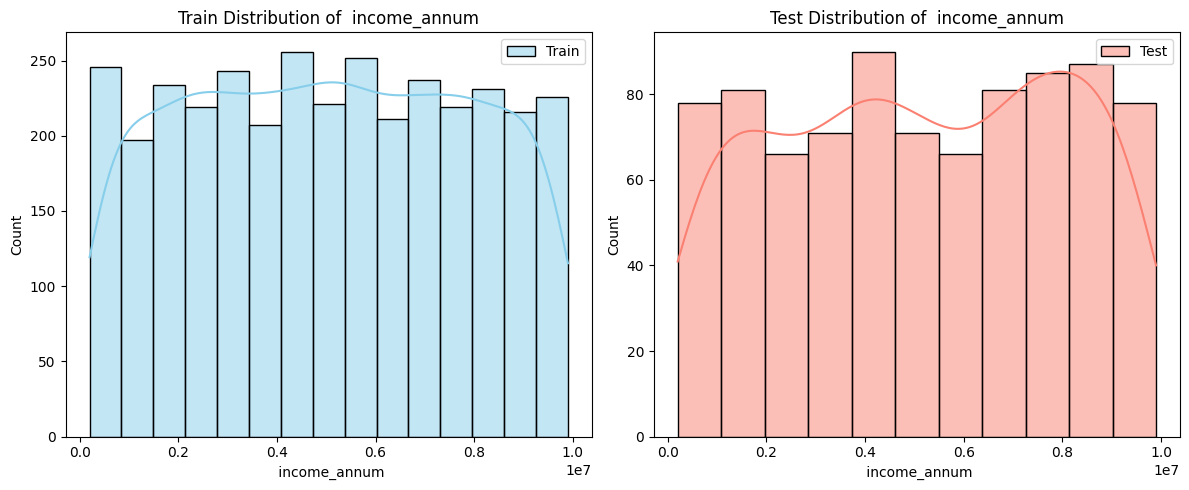

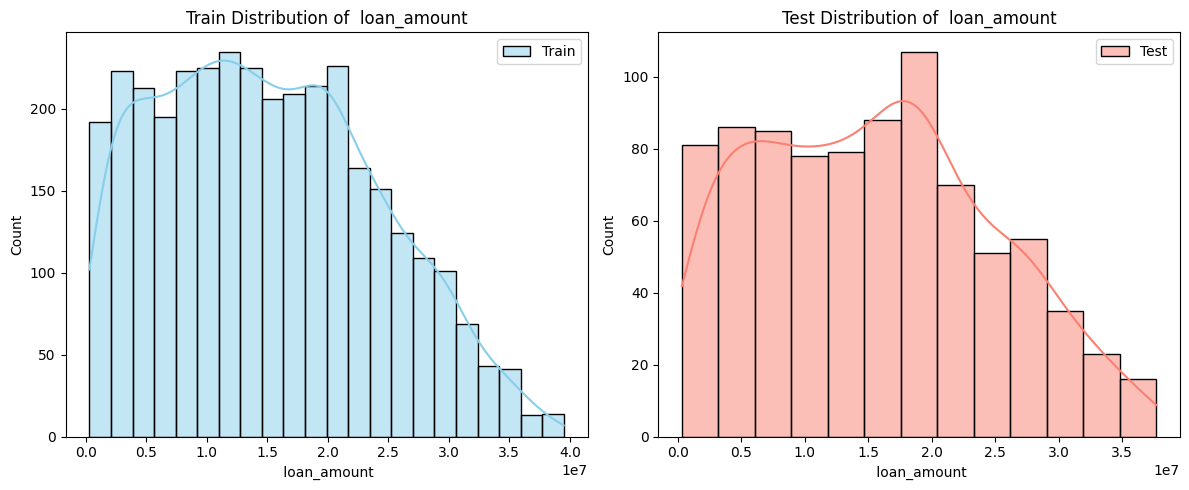

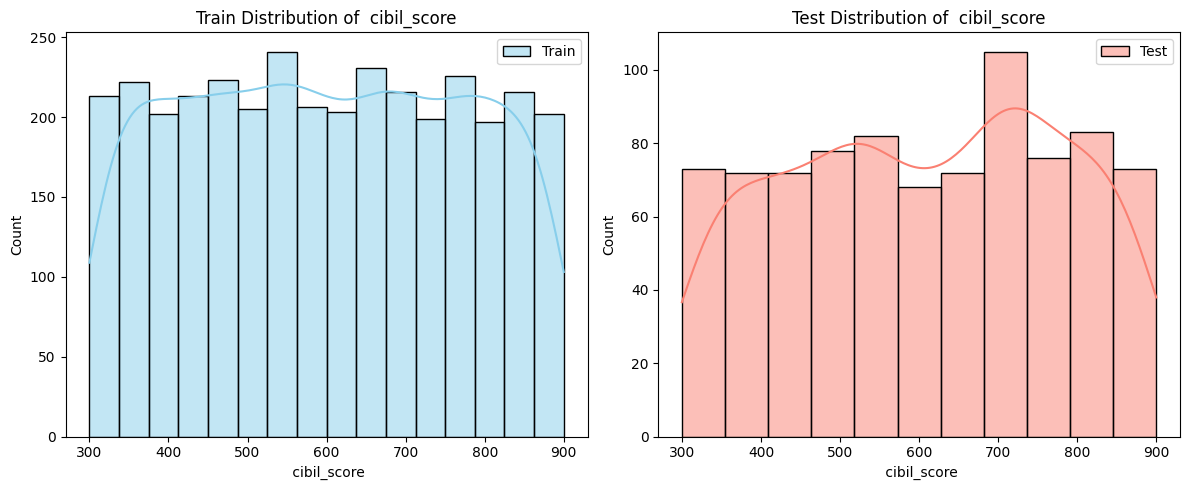

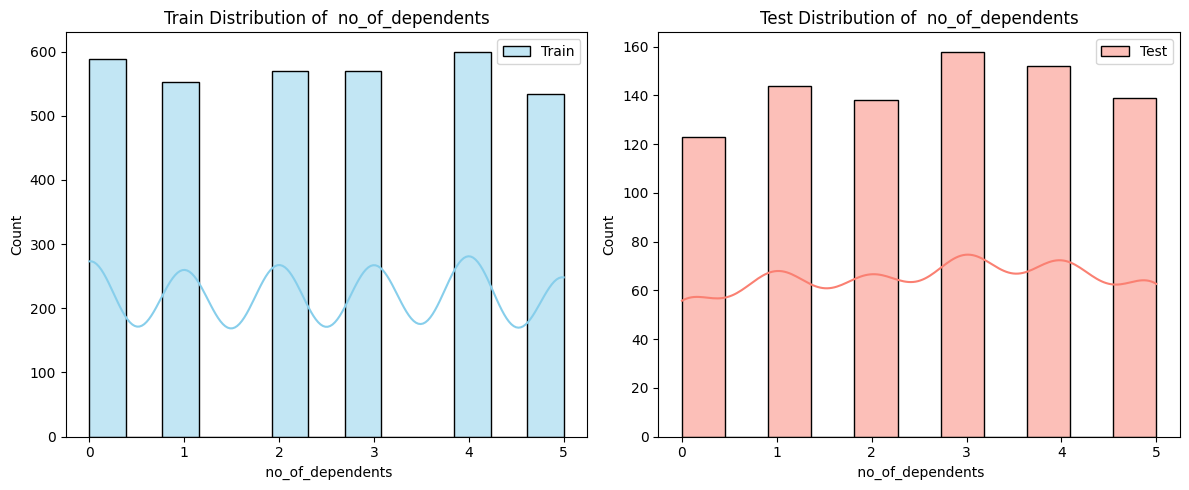

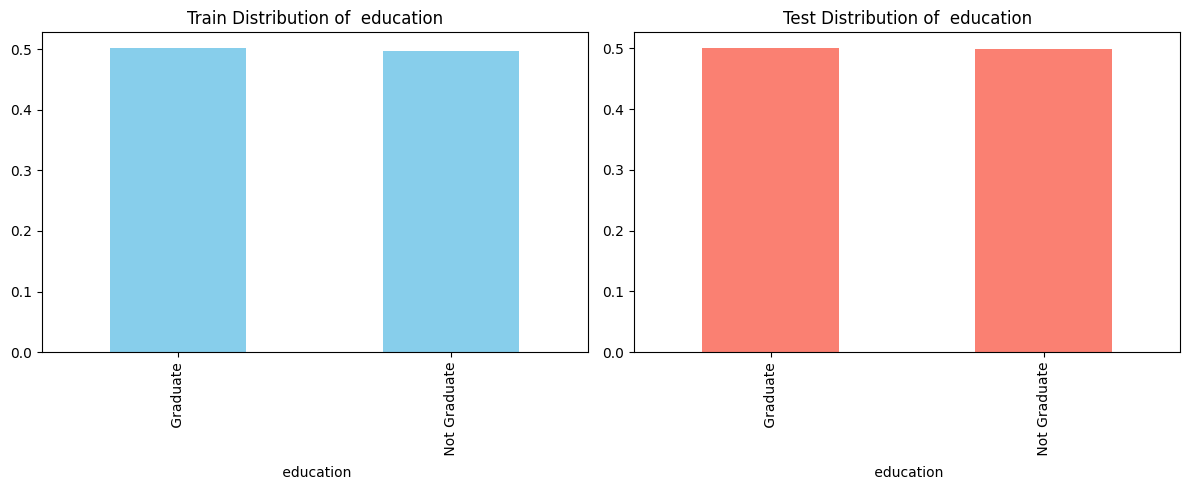

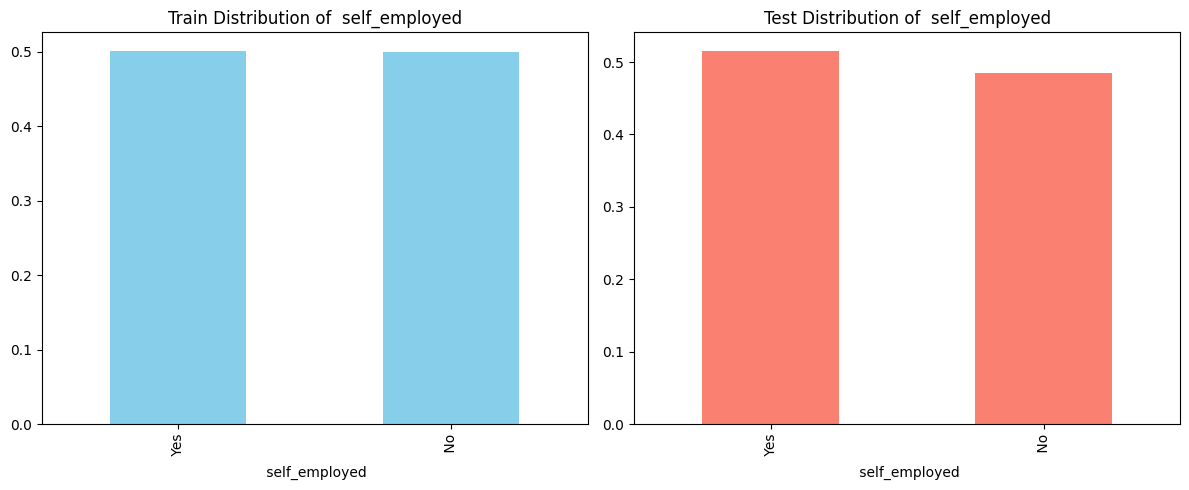

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_distribution_comparison(df_train, df_test, column, plot_type='hist'):
    plt.figure(figsize=(12, 5))

    if plot_type == 'hist':
        plt.subplot(1, 2, 1)
        sns.histplot(df_train[column], kde=True, color='skyblue', label='Train')
        plt.title(f'Train Distribution of {column}')
        plt.legend()

        plt.subplot(1, 2, 2)
        sns.histplot(df_test[column], kde=True, color='salmon', label='Test')
        plt.title(f'Test Distribution of {column}')
        plt.legend()
    elif plot_type == 'bar':
        plt.subplot(1, 2, 1)
        df_train[column].value_counts(normalize=True).plot(kind='bar', color='skyblue')
        plt.title(f'Train Distribution of {column}')

        plt.subplot(1, 2, 2)
        df_test[column].value_counts(normalize=True).plot(kind='bar', color='salmon')
        plt.title(f'Test Distribution of {column}')

    plt.tight_layout()
    plt.show()

# Check numerical columns
numerical_cols_to_check = [' income_annum', ' loan_amount', ' cibil_score', ' no_of_dependents']
for col in numerical_cols_to_check:
    plot_distribution_comparison(X_train, X_test, col, plot_type='hist')

# Check categorical columns
categorical_cols_to_check = [' education', ' self_employed']
for col in categorical_cols_to_check:
    plot_distribution_comparison(X_train, X_test, col, plot_type='bar')
